# Animal Faces Transfer Learning

### This notebook contains the code to carry out the analysis of the transfer learning capacilities of the pre-trained model from task 1 and the ImageNet pre-trained model.
### First, the pre-trained model from task 1 will be loaded to get the CNN encoder to extract features to be passed along to a Logistic Regression model for classification. An analysis of the performance of the classifier will be made with respect to the features extracted.
### Then the same procedure will be done but for a ResNet model with ImageNet pre-trained weights.

#### Colorectal Cancer Pre-trained Model

#### ImageNet Pre-trained Model

In [1]:
import os
import torch
import sklearn.metrics
import matplotlib.pyplot as plt
from numpy import unique
from torch.utils import data
from torch.nn import Flatten
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet50
from torchvision.models import ResNet50_Weights
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
from sklearn.linear_model import LogisticRegression

def load_data(_data_dir="Datasets/Corolectal Cancer/"):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # ResNet
        transforms.RandomHorizontalFlip(),  # Data augmentation
        transforms.ToTensor(),  
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet Normalization
    ])

    if not os.path.exists(_data_dir):
        raise FileNotFoundError(f"Dataset directory '{_data_dir}' does not exist.")

    full_dataset = ImageFolder(root=_data_dir, transform=transform)

    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = data.random_split(full_dataset, [train_size, test_size])

    return train_dataset, test_dataset


device = "cuda:0"

- Get the model from pytorch with a ImageNet preset

In [2]:
imagenet_model = resnet50(weights=ResNet50_Weights.DEFAULT)


- Remove the classification head

In [3]:
# uncomment to see list of layers except fc
# train_nodes, eval_nodes = get_graph_node_names(imagenet_model)
# print(train_nodes[:-1])

return_nodes = {
    'layer1': 'layer1',
    'layer2': 'layer2',
    'layer3': 'layer3',
    'layer4': 'layer4',
    'avgpool': 'avgpool'
}

# Note: this created model does not contain the flatten layer and so the output needs to have that applied first before going to the classifier
imagenet_model = create_feature_extractor(imagenet_model, return_nodes=return_nodes)


- Load the dataset and preprocess it

In [4]:
train_dataset, test_dataset = load_data("Datasets/Animal Faces/")

batch_size = 32

train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


- Get the Logistic Regression model

In [5]:
logistic_regression_classifier = LogisticRegression(random_state=42)


- Extract the features

In [6]:
for param in imagenet_model.parameters():
    param.requires_grad = False

imagenet_model.to(device)

full_train_feature_map_set = None

full_train_label_set = None

full_test_feature_map_set = None

full_test_label_set = None

flatten_layer = Flatten()

for data, label in train_dataloader:
    data, label = data.to(device), label.to(device)

    # Note: the desired output (i.e. output of last layer avgpool) is stored in a dictionary entry along with the rest, end dimensionality is 32x2048
    feature_map_dict = imagenet_model(data)
    flattened_feature_map = flatten_layer(feature_map_dict["avgpool"])

    if full_train_feature_map_set == None:
        full_train_feature_map_set = flattened_feature_map

        full_train_label_set = label
    else:
        full_train_feature_map_set = torch.vstack((full_train_feature_map_set, flattened_feature_map))
        
        full_train_label_set = torch.hstack((full_train_label_set, label))

for data, label in test_dataloader:
    data, label = data.to(device), label.to(device)

    # Note: the desired output (i.e. output of last layer avgpool) is stored in a dictionary entry along with the rest, end dimensionality is 32x2048
    feature_map_dict = imagenet_model(data)
    flattened_feature_map = flatten_layer(feature_map_dict["avgpool"])

    if full_test_feature_map_set == None:
        full_test_feature_map_set = flattened_feature_map

        full_test_label_set = label
    else:
        full_test_feature_map_set = torch.vstack((full_test_feature_map_set, flattened_feature_map))
        
        full_test_label_set = torch.hstack((full_test_label_set, label))


- Pass the features to the training loop for the classifier 

In [7]:
numpy_full_train_feature_map_set = full_train_feature_map_set.cpu().numpy()

numpy_full_train_label_set = full_train_label_set.cpu().numpy()
logistic_regression_classifier.fit(numpy_full_train_feature_map_set, numpy_full_train_label_set)

numpy_full_test_feature_map_set = full_test_feature_map_set.cpu().numpy()
regression_predictions = logistic_regression_classifier.predict(numpy_full_test_feature_map_set)

numpy_full_test_label_set = full_test_label_set.cpu().numpy()
print(f"Logistic Regression test accuracy: {logistic_regression_classifier.score(numpy_full_test_feature_map_set, numpy_full_test_label_set):.2f}%")


Logistic Regression test accuracy: 0.99%


- Plot the results

In [13]:
label_names = ["Cat", "Dog", "Wild"]
print(sklearn.metrics.classification_report(numpy_full_test_label_set, regression_predictions, target_names=label_names))


              precision    recall  f1-score   support

         Cat       1.00      0.99      1.00       384
         Dog       1.00      0.99      0.99       427
        Wild       0.99      1.00      0.99       389

    accuracy                           0.99      1200
   macro avg       0.99      0.99      0.99      1200
weighted avg       0.99      0.99      0.99      1200



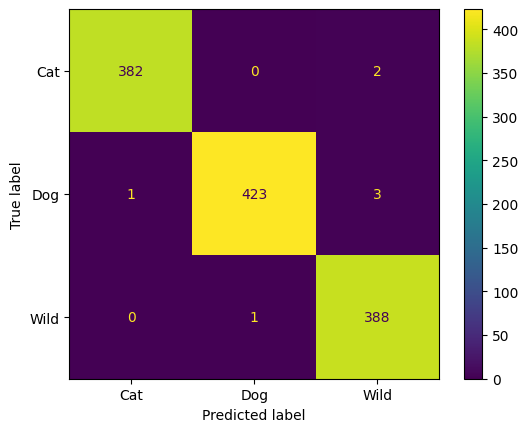

In [27]:
matrix = sklearn.metrics.ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(numpy_full_test_label_set, regression_predictions), display_labels=label_names)
matrix.plot()

plt.show()


- Discussion

- From the information shown in the classification report and the confusion matrix, the following observations can be made
    - Overall, it seems that the ImageNet ResNet model is very good at extracting quality features to help the Logistic Regression model correctly classify the data
    - The classifier produced 7 False Negative (Type I) errors and 7 False Positive (Type II) errors and the majority of those errors came from the "Wild" class
    - The classifier tends to be very consistent thanks to the feature extractor in light of the balance of Type I & II errors